<a href="https://colab.research.google.com/github/quantaosun/NAMD-MD/blob/main/NAMD-MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👋 Hi there.你好👋
This notebook serves as a reference for performing a general molecular dynamics simulation using the open-source package NAMD. It is inspired by the tutorial available at http://zarbi.chem.yale.edu/ligpargen/namd_tutorial.html. The notebook was written by quantaosun@gmail.com in Shanghai, China, in 2021. It focuses on simulating RCSB PDB structures with ligands bound or PDB complexes docked with ligands. By following the steps outlined in this notebook, users can set up and run molecular dynamics simulations using NAMD.


# The tutorial uses an example structure of 2-propylphenol in complex with T4 lysozyme L99A/M102Q (PDB ID: 3HTB.pdb)

**The overall procedure is as below**
0.   PDB structure check and fix with third-party tools or web server.
1.   Installation of Anaconda,pymol, vmd, and openmm, pdbfixer
2.   PDB ID provided by user
3.   Separation of ligand and protein
4.   Topology generation for ligand using LigParGen web server
5.   Combine new ligand pdb and original protein, mannually renumber ligand atom
6.   Generation of ionized.pdb and ionized.psf by VMD, with Charmm force field.
7.   Generation of conf file for NAMD simulation.
8.   GPU accelerted NAMD simulation and copy simualtion data to google drive.


In [1]:
#@title Install conda
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
#@title 👋Mount to Goole Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! yes | conda install -c conda-forge vmd
#@title Install VMD


In [ ]:
#@title Install pymol
!yes | conda install -c conda-forge pymol-open-source

In [ ]:
#@title install openmm
!yes | conda install -c conda-forge openmm

In [ ]:
#@title install pdbfixer
!yes | conda install -c conda-forge pdbfixer

In [ ]:
#@title Install obabel
!conda install -c conda-forge openbabel -y

In [ ]:
#@title Install py3Dmol
!conda install -c conda-forge py3dmol -y

In [ ]:
#@title 1st attempt to install rdkit, there will be an error
!conda install -c conda-forge rdkit -y

In [ ]:
#@title Change conda version
!conda install -c conda-forge conda==23.1.0

In [10]:
#@title Install Rdkit again
!conda install -c conda-forge rdkit -y

In [11]:
#@title Check if your protein has multple chains
import py3Dmol
view = py3Dmol.view(query='pdb:3HTB')
view.setStyle({'cartoon':{'color':'spectrum'}})
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
#@title 👋 2A.Upload a PDB file with a single chain.
PDB_path = "3HTB" #@param {type:"string"}
#!/home/aistudio/external-libraries/bin/pdbfixer  '{PDB_path}' --ph=7  --replace-nonstandard --add-residues

In [12]:
%cd /content/drive/MyDrive/NAMD-MD

/content/drive/MyDrive/NAMD-MD


In [20]:
#@title 👋 2B (Skip this if you finished 2A)Download the PDB file if you are sure this sturcture is ready to simualtion
PDB_ID = "3HTB" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb

--2023-07-03 10:37:39--  https://files.rcsb.org/download/3HTB.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.213.110
Connecting to files.rcsb.org (files.rcsb.org)|132.249.213.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3HTB.pdb’

3HTB.pdb                [  <=>               ] 161.13K   327KB/s    in 0.5s    

2023-07-03 10:37:40 (327 KB/s) - ‘3HTB.pdb’ saved [164997]



In [22]:
#@title 👋 3.Spilit protien and ligand, protein_no_H.pdb and ligand_no_H.pdb should be generated.
ligand_name = "JZ4" #@param {type:"string"}
PDB_path = "3HTB.pdb" #@param {type:"string"}
!grep ATOM '{PDB_path}' > protein_no_H.pdb
!grep HETATM '{PDB_path}' > ligand_1.pdb
!grep '{ligand_name}' ligand_1.pdb > ligand_no_H.pdb

### use pymol to add H
h_add

save the output as "ligand_with_H.pdb"

# 👋 ⚠️4.Uplaod ligand_with_H.pdb to LigParGen to generate PDB,PRM and RTF three files. Then upload them here.
http://zarbi.chem.yale.edu/ligpargen/index.html

In [ ]:
#@title 👋 ⚠️ 5. Combine protien_no_H.pdb and new ligand PDB from LigPargen, a new "complex.pdb" should be created.
com_file = open('combine_protien_ligand.pml','w')
com_file.write('''
load protein_no_H.pdb
load JZ4_0C3F13.pdb
select all
save complex.pdb, all
''')
com_file.close()
! pymol -c combine_protien_ligand.pml

In [ ]:
#@title 6 👋Download Charmm Force Field
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/top_all36_prot.prm
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/top_all36_prot.rtf
!wget https://raw.githubusercontent.com/quantaosun/NAMD-MD/main/toppar_water_ions.mod.str

In [15]:
#@title Psfgen for a single-chained protein with a ligand bound, there might be some warning
com_file = open('psfgen.tcl','w')
com_file.write('''
#psfgen for a single-chained protein with a ligand bound
mol delete all
mol load pdb complex.pdb
set bad [atomselect top "resname ACE"]
if {[info exists bad]} {
set chainB [atomselect top "protein and not hydrogen and not resname ACE NME"]
set chainX [atomselect top "residuetype nothing and not resname ACE NME"]
set flag 1
} else {
set chainB [atomselect top "protein and not hydrogen"]
set chainX [atomselect top "residuetype nothing"]
set flag 0}
$chainB writepdb chainB.pdb
$chainX writepdb chainX.pdb
package require psfgen
topology top_all36_prot.rtf
topology JZ4_0C3F13.rtf
pdbalias HIS HSD
pdbalias atom SER HG HG1
pdbalias residue HIS HSE
pdbalias atom ILE CD1 CD
if {$flag == 1} {
segment B {
  first ACE
  last CT3
  pdb chainB.pdb
}
} else {
segment B {
  first NONE
  last NONE
  pdb chainB.pdb
}
}
segment X {
  first NONE
  last NONE
  pdb chainX.pdb
}
coordpdb chainB.pdb B
coordpdb chainX.pdb X
guesscoord
regenerate angles dihedrals
writepdb psf-complex.pdb
writepsf psf-complex.psf
exit
''')
com_file.close()
!vmd -dispdev text -e psfgen.tcl

/usr/local/lib/vmd_LINUXAMD64: /usr/lib64-nvidia/libGL.so.1: no version information available (required by /usr/local/lib/vmd_LINUXAMD64)
Info) VMD for LINUXAMD64, version 1.9.3 (November 30, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 2 CPUs detected.
Info)   CPU features: SSE2 AVX AVX2 FMA KNL:AVX-512F+CD+ER+PF 
Info) Free system memory: 11GB (88%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator:
Info) [0] Tesla T4           40 SM_7.5 @ 1.59 GHz, 15GB RAM, AE3, ZCP
Info) Detected 1 available TachyonL/OptiX ray tracing accelerator
Inf

In [ ]:
#@title (Skip this)psfgen for a trimer protein with a ligand bound, change the ligand RTF file to yours
mol delete all
mol load pdb complex.pdb
set bad [atomselect top "resname ACE"]
if {[info exists bad]} {
set chainA [atomselect top "chain A and not hydrogen and not resname ACE NME"]
set chainC [atomselect top "chain C and not hydrogen and not resname ACE NME"]
set chainB [atomselect top "chain B and not hydrogen and not resname ACE NME"]
set chainX [atomselect top "residuetype nothing and not resname ACE NME"]
set flag 1
} else {
set chainA [atomselect top "chain A and not hydrogen"]
set chainC [atomselect top "chain C and not hydrogen"]
set chainB [atomselect top "chain B and not hydrogen"]
set chainX [atomselect top "residuetype nothing"]
set flag 0}
$chainA writepdb chainA.pdb
$chainC writepdb chainC.pdb
$chainB writepdb chainB.pdb
$chainX writepdb chainX.pdb
package require psfgen
topology top_all36_prot.rtf
topology ../5_reference.rtf
pdbalias HIS HSD
pdbalias atom SER HG HG1
pdbalias residue HIS HSE
pdbalias atom ILE CD1 CD
if {$flag == 1} {
segment A {
  first ACE
  last CT3
  pdb chainA.pdb
}
segment C {
  first ACE
  last CT3
  pdb chainC.pdb
}
segment B {
  first ACE
  last CT3
  pdb chainB.pdb
}
} else {
segment A {
  first NONE
  last NONE
  pdb chainA.pdb
}
segment C {
  first NONE
  last NONE
  pdb chainC.pdb
}
segment B {
  first NONE
  last NONE
  pdb chainB.pdb
}
}
segment X {
  first NONE
  last NONE
  pdb chainX.pdb
}
coordpdb chainA.pdb A
coordpdb chainC.pdb C
coordpdb chainB.pdb B
coordpdb chainX.pdb X
guesscoord
regenerate angles dihedrals
writepdb psf-complex.pdb
writepsf psf-complex.psf
exit

In [ ]:
#@title (Skip this) Load your membrane: VMD Main-File-New Molecule-Browse(popc(pore_r=24).pdb psf） https://www.charmm-gui.org/archive/bilayer/popc.tar.gz
#generate popc_autopsf.pdb psf: Extensions-Modeling-Automatic PSF Builder-Load input files(top_all36_cgenff.rtf & par_all36_lipid.prm)-Guess and split..-Create chains(without water)
#generate complex_popc_raw.pdb psf
set popc [atomselect top all]
set kcsamol [mol load psf psf-complex.psf pdb psf-complex.pdb]
set kcsa [atomselect $kcsamol all]
$popc moveby [vecinvert [measure center $popc weight mass]] #may optioned
$popc writepdb popc_TEMP.pdb
set vest [atomselect $kcsamol "protein and resid 327 to 333"] #the number of residues is up to your protein
$kcsa moveby [vecinvert [measure center $vest weight mass]]
display resetview
$kcsa move [transaxis z -25] #Rotate around the z axis
$kcsa writepdb kcsa_TEMP.pdb
mol delete all
package require psfgen
resetpsf
readpsf popc_autopsf.psf #name of your memrane psf file
coordpdb popc_TEMP.pdb
readpsf psf-complex.psf
coordpdb kcsa_TEMP.pdb
writepsf complex_popc.psf
writepdb complex_popc.pdb
file delete kcsa_TEMP.pdb
file delete popc_TEMP.pdb

In [ ]:
#Solvate and add ions to membrane_system
com_file = open('solvate.tcl','w')
com_file.write('''
package require solvate
solvate psf-complex.psf psf-complex.pdb -t 15 -o complex_wb
package require autoionize
autoionize -psf complex_wb.psf -pdb complex_wb.pdb -sc 0.15 -cation SOD -o ionized
exit
''')
com_file.close()
!vmd -dispdev text -e solvate.tcl

In [ ]:
#@title (Optional) Make restrains
com_file = open('restrain.tcl','w')
com_file.write('''
mol delete all
mol load pdb ionized.pdb
set all [atomselect top "all"]
set sel [atomselect top "protein and name CA"]
$all set beta 0
$sel set beta 1
$all writepdb restrained.pdb
exit
''')
com_file.close()
!vmd -dispdev text -e restrain.tcl

In [ ]:
#@title Measure the dimentions
com_file = open('measure.tcl','w')
com_file.write('''
mol delete all
mol load pdb ionized.pdb
set ubq [atomselect top all]
measure minmax $ubq
measure center $ubq
''')
com_file.close()
!vmd -dispdev text -e measure.tcl

## Modify NAMD configuration files
Three parts in nvt.namd need modification, same for npt.namd

In [ ]:
# Periodic Boundary Conditions
cellBasisVector1 ? 0 0
cellBasisVector2 0 ? 0
cellBasisVector3 0 0 ?
cellOrigin ? ? ?
wrapAll on
# PME (for full-system periodic electrostatics)
PME yes
PMEGridSizeX ? ;# product of 2,3,5, slightly bigger than box vector
PMEGridSizeY ? ;# product of 2,3,5
PMEGridSizeZ ? ;# product of 2,3,5

[链接文字](`https://`)Modify configuration file
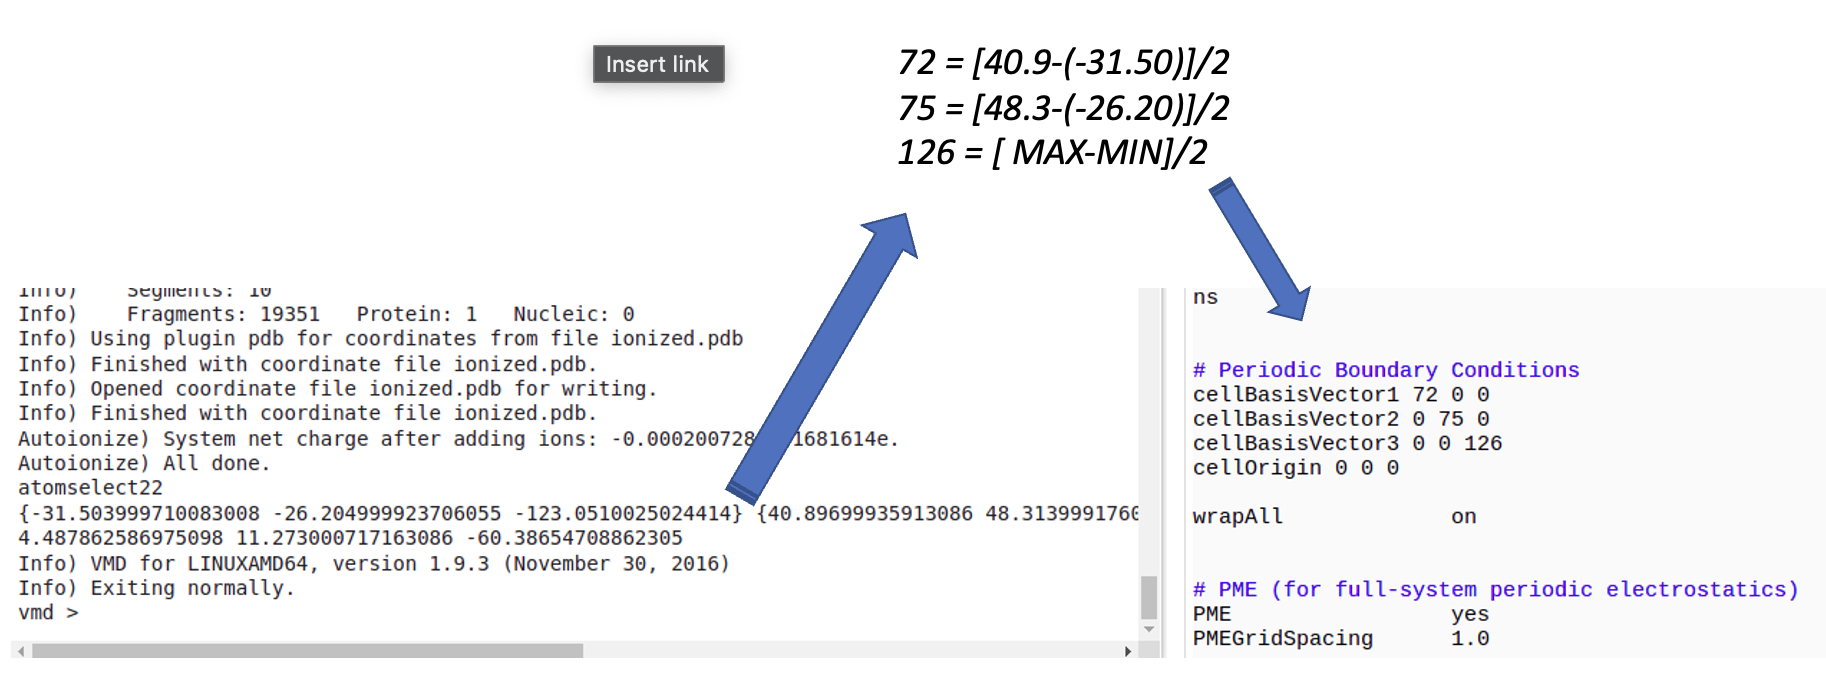


In [ ]:
paraTypeCharmm on

parameters                        top_all36_prot.prm
parameters                        ???????????
parameters                        toppar_water_ions.mod.str

In [ ]:
run ???????? ;# 5000ps

## Ready to simulate with NAMD